In [1]:
!pip install pystan~=2.14
!pip install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

# Catfish Sales Data

In [3]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [4]:
url = "https://raw.githubusercontent.com/anhnguyendepocen/Time-Series-Analysis-1/master/catfish.csv"
catfish_sales = pd.read_csv(url, parse_dates=[0], index_col=0, date_parser=parser)

In [5]:
catfish_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1986-01-01 to 2012-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Total   324 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [6]:
catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

,Total
Date,
1986-01-01,9034
1986-02-01,9596
1986-03-01,10558
1986-04-01,9002
1986-05-01,9239
...,...
2012-08-01,14442
2012-09-01,13422
2012-10-01,13795


## Seasonal Decompose

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

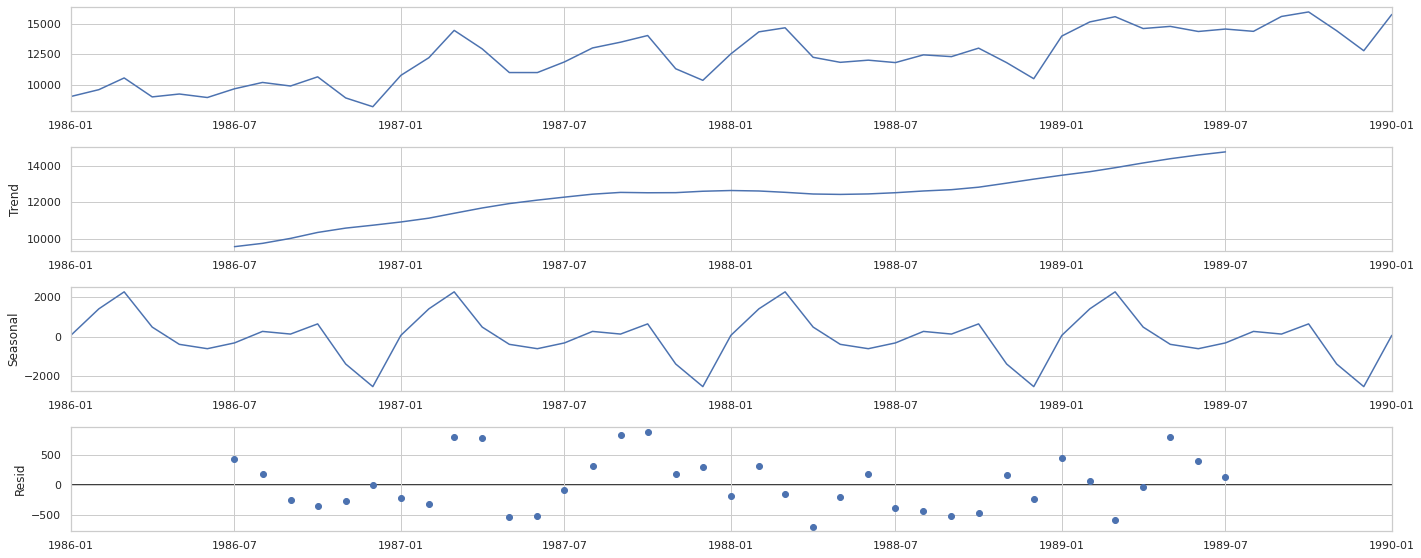

In [9]:
plt.rc('figure',figsize=(20,8))
plt.rc('font',size=15)

result = seasonal_decompose(catfish_sales.loc[:"1990-01-01"], model='additive')
fig = result.plot()

## Isolation forest

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

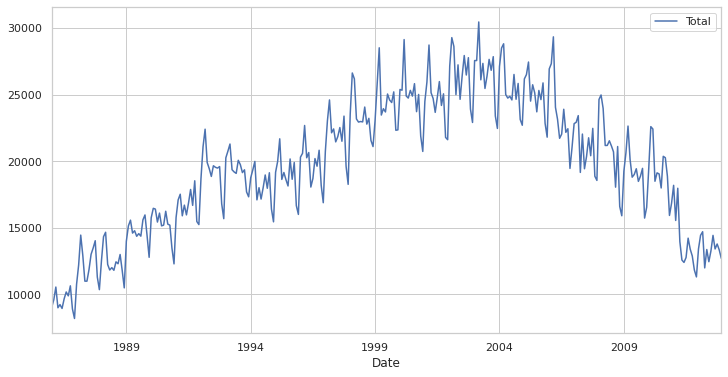

In [11]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
catfish_sales.plot()

In [12]:
url = "https://raw.githubusercontent.com/anhnguyendepocen/Time-Series-Analysis-1/master/catfish.csv"
catfish_sales = pd.read_csv(url, parse_dates=[0], index_col=0, date_parser=parser)

catfish_sales.loc["1998-12-1"]['Total'] = 10000
catfish_sales.loc["1990-12-1"]['Total'] = 23000
catfish_sales.loc["1993-3-1"]['Total'] = 30000
catfish_sales.loc["2003-3-1"]['Total'] = 35000

In [13]:
outliers_fraction = float(.01)

In [14]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(catfish_sales.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [15]:
model =  IsolationForest(contamination=outliers_fraction, n_estimators=500)
model.fit(data) 

IsolationForest(contamination=0.01, n_estimators=500)

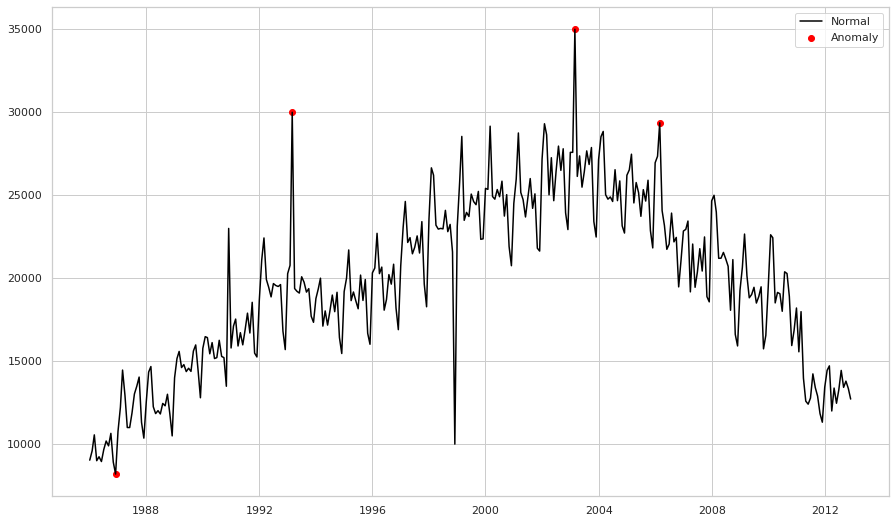

In [16]:
catfish_sales['anomaly'] = model.predict(data)

fig, ax = plt.subplots(figsize=(15,9))

a = catfish_sales.loc[catfish_sales['anomaly'] == -1, ['Total']] #anomaly

ax.plot(catfish_sales.index, catfish_sales['Total'], color='black', label = 'Normal')
ax.scatter(a.index,a['Total'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

## Forecasting with fbprophet

In [17]:
from fbprophet import Prophet

In [18]:
df = pd.DataFrame()
df['ds'] = catfish_sales.index
df['y'] = catfish_sales['Total'].values

In [19]:
df.tail(15)

,ds,y
309,2011-10-01,12893
310,2011-11-01,11843
311,2011-12-01,11321
312,2012-01-01,13427
313,2012-02-01,14447
314,2012-03-01,14717
315,2012-04-01,11998
316,2012-05-01,13379
317,2012-06-01,12463
318,2012-07-01,13276


In [20]:
df.shape

(324, 2)

In [21]:
df.y.describe()

count      324.000000
mean     19683.450617
std       5121.715529
min       8196.000000
25%      15764.000000
50%      19660.500000
75%      23697.500000
max      35000.000000
Name: y, dtype: float64

In [22]:
df

,ds,y
0,1986-01-01,9034
1,1986-02-01,9596
2,1986-03-01,10558
3,1986-04-01,9002
4,1986-05-01,9239
...,...,...
319,2012-08-01,14442
320,2012-09-01,13422
321,2012-10-01,13795
322,2012-11-01,13352


In [23]:
m = Prophet()
m.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
future = m.make_future_dataframe(periods=36, freq="M")
future.tail(15)

,ds
345,2014-09-30
346,2014-10-31
347,2014-11-30
348,2014-12-31
349,2015-01-31
350,2015-02-28
351,2015-03-31
352,2015-04-30
353,2015-05-31
354,2015-06-30


In [25]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
355,2015-07-31,10371.767282,8288.432229,12376.068083
356,2015-08-31,9383.257839,7339.259635,11357.977477
357,2015-09-30,9260.420079,7249.069709,11252.193690
358,2015-10-31,5677.638197,3747.368075,7772.161804
359,2015-11-30,5905.077612,3802.397215,8035.856511


In [26]:
forecast["on_off"] = np.random.randint(2, size=360)

In [27]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,on_off
355,2015-07-31,9139.605245,8288.432229,12376.068083,8695.276919,9559.567196,1232.162038,1232.162038,1232.162038,1232.162038,1232.162038,1232.162038,0.0,0.0,0.0,10371.767282,1
356,2015-08-31,9006.305806,7339.259635,11357.977477,8538.382803,9461.894909,376.952033,376.952033,376.952033,376.952033,376.952033,376.952033,0.0,0.0,0.0,9383.257839,0
357,2015-09-30,8877.306349,7249.069709,11252.193690,8386.977193,9367.063673,383.113730,383.113730,383.113730,383.113730,383.113730,383.113730,0.0,0.0,0.0,9260.420079,0
358,2015-10-31,8744.006910,3747.368075,7772.161804,8226.689454,9255.321200,-3066.368713,-3066.368713,-3066.368713,-3066.368713,-3066.368713,-3066.368713,0.0,0.0,0.0,5677.638197,0
359,2015-11-30,8615.007452,3802.397215,8035.856511,8060.836262,9151.146342,-2709.929841,-2709.929841,-2709.929841,-2709.929841,-2709.929841,-2709.929841,0.0,0.0,0.0,5905.077612,0


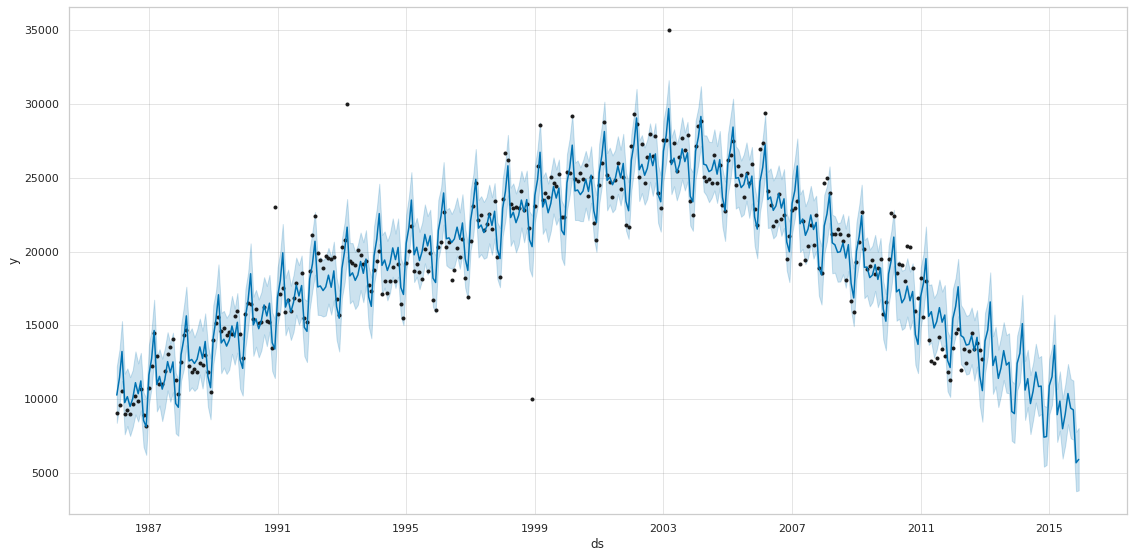

In [28]:
fig1 = m.plot(forecast, figsize=(16, 8))

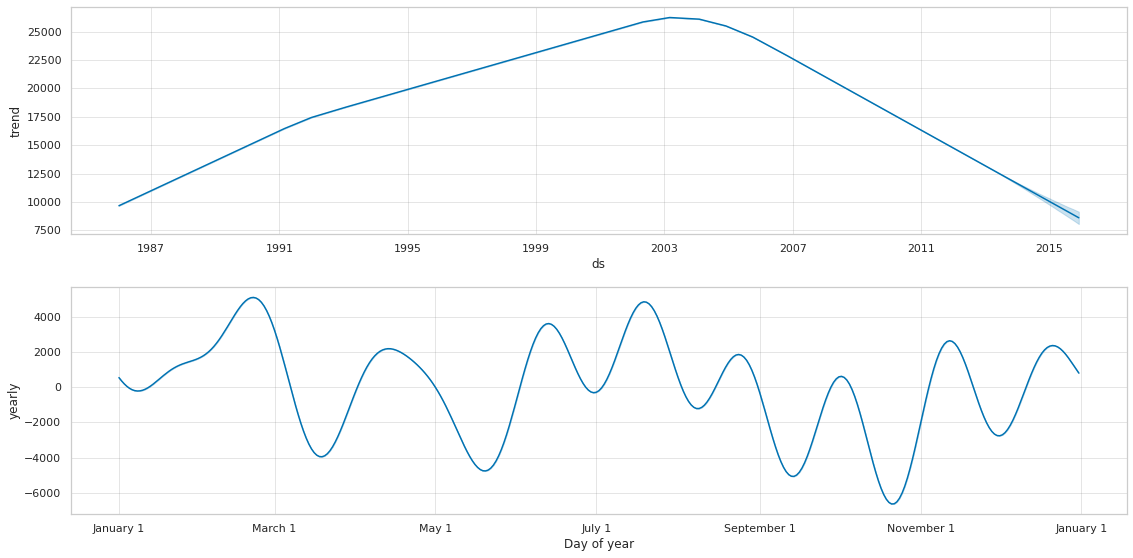

In [29]:
fig2 = m.plot_components(forecast, figsize=(16, 8))


In [30]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast, figsize=(1300, 700))

In [31]:
plot_components_plotly(m, forecast, figsize=(1300, 200))